In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pmdarima as pm
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from sklearn.model_selection import ParameterGrid
from pmdarima import auto_arima

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.2 MB/s eta 0:00:00


In [ ]:
#df = pd.read_csv("/content/exchange_rate.csv")
#df['date'] = pd.to_datetime(df['date'], utc=True)

#"national_illness"

data_name = "exchange_rate"

df = pd.read_csv(f"/content/{data_name}.csv")
df['date'] = pd.to_datetime(df['date'], utc=True)

In [ ]:
series = df['OT']
series.info()

<class 'pandas.core.series.Series'>
RangeIndex: 966 entries, 0 to 965
Series name: OT
Non-Null Count  Dtype
--------------  -----
966 non-null    int64
dtypes: int64(1)
memory usage: 7.7 KB


In [ ]:
train, test = train_test_split(series, test_size=0.2, random_state=123)

## Test for stationarity

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(train)

In [ ]:
plot_pacf(train)

In [ ]:
plt.plot(series, color='blue')
plt.xlabel('Date')
plt.ylabel('Exchange rate')

In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(train)
print(f"p-values: {adf_test[0]}")

p-values: -13.346244339212594


# Helper functions

In [ ]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

## Fit model

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train.values, order=(2,1,0))
model_fit = model.fit()
print(model_fit.summary())

In [ ]:
residuals = model_fit.resid
res = pd.DataFrame(model_fit.resid)
print(res.describe())
plt.plot(residuals)

In [ ]:
forecast_test = model_fit.forecast(len(test))

df['forecast'] = [None]*len(train) + list(forecast_test)

forecast_df = df[['forecast', 'OT']]

forecast_df.plot()


In [ ]:
forecast_test

array([0.69129034, 0.69453622, 0.6792037 , ..., 0.68633803, 0.68633803,
       0.68633803])

## Auto Arima

In [ ]:
auto_arima = pm.auto_arima(train, stepwise=True, seasonal=True)
auto_arima

In [ ]:
forecast_test_auto = auto_arima.predict(n_periods=len(test))
df['forecast_auto'] = [None]*len(train) + list(forecast_test_auto)

forecast_df = df[['forecast_auto', 'OT']]

forecast_df.plot()

In [ ]:
mae = mean_absolute_error(test, forecast_test)
mape = mean_absolute_percentage_error(test, forecast_test)
rmse = np.sqrt(mean_squared_error(test, forecast_test))

print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

In [ ]:
mae = mean_absolute_error(test, forecast_test_auto)
mape = mean_absolute_percentage_error(test, forecast_test_auto)
rmse = np.sqrt(mean_squared_error(test, forecast_test_auto))

print(f'mae - auto: {mae}')
print(f'mape - auto: {mape}')
print(f'rmse - auto: {rmse}')

# Multivariate forecasting

## Pre-processing

In [ ]:
Xy = df.set_index("date")

### Normalize

In [ ]:
avgs = Xy.mean()
devs = Xy.std()

In [ ]:
for col in Xy.columns:
    Xy[col] = (Xy[col] - avgs.loc[col]) / devs.loc[col]

### Remove Trend

In [ ]:
Xy = Xy.diff().dropna()

In [ ]:
annual_volatility = Xy.groupby(Xy.index.year).std()

In [ ]:
Xy['0_annual_vol'] = Xy.index.map(lambda d: annual_volatility.loc[d.year, '0'])
Xy['1_annual_vol'] = Xy.index.map(lambda d: annual_volatility.loc[d.year, '1'])
Xy['2_annual_vol'] = Xy.index.map(lambda d: annual_volatility.loc[d.year, '2'])
Xy['3_annual_vol'] = Xy.index.map(lambda d: annual_volatility.loc[d.year, '3'])
Xy['4_annual_vol'] = Xy.index.map(lambda d: annual_volatility.loc[d.year, '4'])
Xy['5_annual_vol'] = Xy.index.map(lambda d: annual_volatility.loc[d.year, '5'])
Xy['6_annual_vol'] = Xy.index.map(lambda d: annual_volatility.loc[d.year, '6'])
Xy['OT_annual_vol'] = Xy.index.map(lambda d: annual_volatility.loc[d.year, 'OT'])

In [ ]:
Xy['0'] = Xy['0'] / Xy['0_annual_vol']
Xy['1'] = Xy['1'] / Xy['1_annual_vol']
Xy['2'] = Xy['2'] / Xy['2_annual_vol']
Xy['3'] = Xy['3'] / Xy['3_annual_vol']
Xy['4'] = Xy['4'] / Xy['4_annual_vol']
Xy['5'] = Xy['5'] / Xy['5_annual_vol']
Xy['6'] = Xy['6'] / Xy['6_annual_vol']
Xy['OT'] = Xy['OT'] / Xy['OT_annual_vol']

In [ ]:
month_avgs = Xy.groupby(Xy.index.month).mean()

In [ ]:
Xy['0_month_avg'] = Xy.index.map(lambda d: month_avgs.loc[d.month, '0'])
Xy['1_month_avg'] = Xy.index.map(lambda d: month_avgs.loc[d.month, '1'])
Xy['2_month_avg'] = Xy.index.map(lambda d: month_avgs.loc[d.month, '2'])
Xy['3_month_avg'] = Xy.index.map(lambda d: month_avgs.loc[d.month, '3'])
Xy['4_month_avg'] = Xy.index.map(lambda d: month_avgs.loc[d.month, '4'])
Xy['5_month_avg'] = Xy.index.map(lambda d: month_avgs.loc[d.month, '5'])
Xy['6_month_avg'] = Xy.index.map(lambda d: month_avgs.loc[d.month, '6'])
Xy['OT_month_avg'] = Xy.index.map(lambda d: month_avgs.loc[d.month, 'OT'])

In [ ]:
Xy['0'] = Xy['0'] - Xy['0_month_avg']
Xy['1'] = Xy['1'] - Xy['1_month_avg']
Xy['2'] = Xy['2'] - Xy['2_month_avg']
Xy['3'] = Xy['3'] - Xy['3_month_avg']
Xy['4'] = Xy['4'] - Xy['4_month_avg']
Xy['5'] = Xy['5'] - Xy['5_month_avg']
Xy['6'] = Xy['6'] - Xy['6_month_avg']
Xy['OT'] = Xy['OT'] - Xy['OT_month_avg']

In [ ]:
Xy = Xy[['0', '1', '2', '3', '4', '5', '6', 'OT']]

In [ ]:
X, y = train_test_split(Xy, test_size=0.05, random_state=123)

# VARMA

In [ ]:
Xy = df.set_index("date")

## ADF test for stationarity

In [ ]:
for column in Xy.columns:
  result = adfuller(Xy[column], autolag='AIC')

  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')

  for key, value in result[4].items():
      print('\t%s: %.3f' % (key, value))
  if result[0] < result[4]["5%"]:
      print ("Reject Ho - Time Series is Stationary")
  else:
      print ("Failed to Reject Ho - Time Series is Non-Stationary")

In [ ]:
# Then test if making one or all series stationary impacts model performance, e.g a linear model.

### Non-stationary columns

In [ ]:
plt.plot(Xy['NUM. OF PROVIDERS'], color='blue')
plt.xlabel('Date')
plt.ylabel('NUM. OF PROVIDERS')

In [ ]:
plt.plot(Xy['OT'], color='blue')
plt.xlabel('Date')
plt.ylabel('OT')

In [ ]:
# Difference to make it stationary
Xy_diff = Xy.diff()
Xy_diff.iloc[0] = Xy.iloc[0]

In [ ]:
for column in Xy_diff.columns:
  result = adfuller(Xy_diff[column], autolag='AIC')

  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')

  for key, value in result[4].items():
      print('\t%s: %.3f' % (key, value))
  if result[0] < result[4]["5%"]:
      print ("Reject Ho - Time Series is Stationary")
  else:
      print ("Failed to Reject Ho - Time Series is Non-Stationary")

## Train model

In [ ]:
pred_len = 24

pred_lens = [96, 192, 336, 720]
#[24 , 36, 48, 60]
#[96 192 336 720]

In [ ]:
#X, y = Xy[0:-pred_len], Xy[-pred_len:]
#X, y = Xy_diff[0:-pred_len], Xy_diff[-pred_len:]

## Hyperparameter tuning

In [ ]:
param_grid = {'p': [1,2,3], 'q':[1,2,3]}
pg = list(ParameterGrid(param_grid))

In [ ]:
def find_opt_params(train, test):
  df_results = pd.DataFrame(columns=['p', 'q','mae','mse'])
  print('Starting grid search...')
  for a,b in enumerate(pg):
      p = b.get('p')
      q = b.get('q')
      model_fit = VARMAX(train, order=(p,q)).fit()
      forecast_test = model_fit.forecast(len(test))

      mae = mean_absolute_error(test, forecast_test)
      mse = mean_squared_error(test, forecast_test)
      df_results = df_results.append({'p': p, 'q': q, 'mae': mae, 'mse': mse}, ignore_index=True)
  return list(df_results.sort_values('mae', ascending=True)[['p', 'q']].iloc[0])

In [ ]:
r = Xy.copy()

X, y = Xy[0:-24], Xy[-24:]

print(f"Fitting model (pred_len={24})...")
# Find optimal parameters and fit model
var_model = VARMAX(X, order=(3, 2))
model_fit = var_model.fit()

print(f"Testing model (pred_len={24})...")
# Forecast model
forecast_test = model_fit.forecast(len(y))
r['forecast_' + str(pred_len)] = [None]*len(X) + list(forecast_test['OT'])
r['residuals_' + str(pred_len)] = pd.concat([model_fit.resid['OT'], y['OT'] - forecast_test['OT']], axis = 0)

# Calculate metrics
mae = mean_absolute_error(y, forecast_test)
mse = mean_squared_error(y, forecast_test)

print(f'VARMA:\n data={data_name} \n pred_len={24} \n order={36, 24} \n mae={mae} \n mse={mse}')

In [ ]:
def inverse_diff_func(actual_df, pred_df):
    '''
    Transforms the differentiated values back
    
    Args:
        actual dataframe (float64): Values of the columns, numpy array of floats 
        predicted dataframe (float64): Values of the columns, numpy array of floats 
    
    Returns:
        Dataframe with the predicted values
    '''
    df_temp = pred_df.copy()
    columns = actual_df.columns
    for col in columns: 
        df_temp[str(col)+'_inv_diff'] = actual_df[col].iloc[-1] + df_temp[str(col)].cumsum()
    return df_temp

## Fit models

In [ ]:
def find_opt_params(train, test):
  df_results = pd.DataFrame(columns=['p', 'q','mae','mse'])
  print('Starting grid search...')
  for a,b in enumerate(pg):
      p = b.get('p')
      q = b.get('q')
      model_fit = VARMAX(train, order=(p,q)).fit()
      forecast_test = model_fit.forecast(len(test))

      mae = mean_absolute_error(test, forecast_test)
      mse = mean_squared_error(test, forecast_test)
      df_results = df_results.append({'p': p, 'q': q, 'mae': mae, 'mse': mse}, ignore_index=True)
  return list(df_results.sort_values('mae', ascending=True)[['p', 'q']].iloc[0])

def find_order_auto_arima(X):
  print(f'Searching order of p and q for : OT')
  stepwise_model = auto_arima(X['OT'],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=False,
      trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
  parameter = stepwise_model.get_params().get('order')
  print(f'optimal order for: OT is: {parameter} \n\n')
  return stepwise_model.get_params().get('order')

def train_test_varma():
  print(f"Starting training...")
  summary_df = pd.DataFrame(columns=['Run','MAE', 'MSE'])

  for pred_len in pred_lens:

    # Split into Train and Test data based on pred len
    X, y = Xy[0:-pred_len], Xy[-pred_len:]

    print(f"Fitting model (pred_len={pred_len})...")
    # Find optimal parameters and fit model
    optimal_order = find_order_auto_arima(X)
    print(f"Found optimal params={optimal_order})...")
    var_model = VARMAX(X, order=(optimal_order[0], optimal_order[2]))
    model_fit = var_model.fit()

    print(f"Testing model (pred_len={pred_len})...")
    # Forecast model
    forecast_test = model_fit.forecast(len(y))
    results_df['forecast_' + str(pred_len)] = [None]*len(X) + list(forecast_test['OT'])
    results_df['residuals_' + str(pred_len)] = pd.concat([model_fit.resid['OT'], y['OT'] - forecast_test['OT']], axis = 0)

    # Calculate metrics
    mae = mean_absolute_error(y['OT'], forecast_test['OT'])
    mse = mean_squared_error(y['OT'], forecast_test['OT'])
    summary_df = summary_df.append({'Run': f'VARMA_raw_{data_name}_{pred_len}', 'MAE': mae, "MSE": mse}, ignore_index=True)

    summary = f'VARMA:\n data={data_name} \n pred_len={pred_len} \n order={optimal_order} \n mae={mae} \n mse={mse}'

    with open(f"summary_VARMA_raw_{data_name}_{pred_len}.txt", "w") as text_file:
      text_file.write(summary)

    print(summary)

  results_df.to_csv(f"results_VARMA_raw_{data_name}.csv", index=False)

  print("Training done...")

  return summary_df

def train_test_varma_dif():
  print(f"Starting training...")
  summary_df = pd.DataFrame(columns=['Run','MAE', 'MSE'])

  for pred_len in pred_lens:

    # Split into Train and Test data based on pred len
    X, y = Xy[0:-pred_len], Xy[-pred_len:]

    # Difference data
    X_dif = X.diff()
    X_dif.iloc[0] = X.iloc[0]

    print(f"Fitting model (pred_len={pred_len})...")
    # Find optimal parameters and fit model
    optimal_order = find_order_auto_arima(X_dif)
    print(f"Found optimal params={optimal_order})...")
    var_model = VARMAX(X_dif, order=(optimal_order[0], optimal_order[2]))
    model_fit = var_model.fit()

    print(f"Testing model (pred_len={pred_len})...")
    # Forecast model
    result = model_fit.forecast(len(y))
    
    df_pred = pd.DataFrame(result, columns=X_dif.columns)
    df_pred["new_index"] = range(len(X), len(Xy))
    df_pred = df_pred.set_index("new_index")

    res = inverse_diff_func(X, df_pred)

    results_df['forecast_' + str(pred_len)] = [None]*len(X_dif) + list(res['OT_inv_diff'])
    results_df['residuals_' + str(pred_len)] = pd.concat([model_fit.resid['OT'], y['OT'] - res['OT_inv_diff']], axis = 0)

    # Calculate metrics
    mae = mean_absolute_error(y['OT'], res['OT_inv_diff'])
    mse = mean_squared_error(y['OT'], res['OT_inv_diff'])
    summary_df = summary_df.append({'Run': f'VARMA_diff_{data_name}_{pred_len}', 'MAE': mae, "MSE": mse}, ignore_index=True)

    summary = f'VARMA:\n data={data_name} \n pred_len={pred_len} \n order={optimal_order} \n mae={mae} \n mse={mse}'

    with open(f"summary_VARMA_diff_{data_name}_{pred_len}.txt", "w") as text_file:
      text_file.write(summary)

    print(summary)

  results_df.to_csv(f"results_VARMA_diff_{data_name}.csv", index=False)

  print("Training done...")

  return summary_df

In [ ]:
results_df = Xy.copy()
summary_df = train_test_varma()
summary_df

Starting training...
Fitting model (pred_len=96)...
Searching order of p and q for : OT
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-58516.959, Time=3.94 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-58502.135, Time=0.65 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-58518.958, Time=0.93 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-58518.947, Time=2.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-58504.032, Time=0.64 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-58516.958, Time=3.77 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-58496.118, Time=3.89 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-58520.845, Time=0.39 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-58518.845, Time=0.59 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-58518.846, Time=1.50 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-58520.833, Time=0.87 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-58498.028, Time=1.06 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total 

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing model (pred_len=96)...
VARMA:
 data=exchange_rate 
 pred_len=96 
 order=(1, 1, 0) 
 mae=0.021634093183790632 
 mse=0.0006542305160555546
Fitting model (pred_len=192)...
Searching order of p and q for : OT
Performing stepwise search to minimize aic


<ipython-input-19-72631c321438>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append({'Run': f'VARMA_raw_{data_name}_{pred_len}', 'MAE': mae, "MSE": mse}, ignore_index=True)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-57759.795, Time=8.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-57745.301, Time=1.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-57761.765, Time=0.79 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-57761.722, Time=3.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-57747.215, Time=0.33 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-57759.775, Time=1.43 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-57739.285, Time=5.55 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-57763.670, Time=0.33 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-57761.681, Time=0.49 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-57761.702, Time=0.91 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-57763.627, Time=0.81 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-57741.211, Time=1.14 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 24.338 seconds
optimal order for: OT is: (1, 1, 0) 


Found optimal params=(1, 1, 0))...


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing model (pred_len=192)...
VARMA:
 data=exchange_rate 
 pred_len=192 
 order=(1, 1, 0) 
 mae=0.010310872551107565 
 mse=0.00016027431404994565
Fitting model (pred_len=336)...
Searching order of p and q for : OT
Performing stepwise search to minimize aic


<ipython-input-19-72631c321438>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append({'Run': f'VARMA_raw_{data_name}_{pred_len}', 'MAE': mae, "MSE": mse}, ignore_index=True)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-56655.982, Time=3.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-56642.095, Time=0.64 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-56657.866, Time=0.88 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-56657.784, Time=1.97 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-56644.077, Time=0.33 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-56655.905, Time=1.93 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-56636.079, Time=3.36 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-56659.846, Time=0.28 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-56657.886, Time=0.48 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-56657.964, Time=0.95 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-56659.764, Time=0.79 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-56638.072, Time=1.71 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 16.925 seconds
optimal order for: OT is: (1, 1, 0) 


Found optimal params=(1, 1, 0))...


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing model (pred_len=336)...
VARMA:
 data=exchange_rate 
 pred_len=336 
 order=(1, 1, 0) 
 mae=0.05164815512522882 
 mse=0.003189733703354014
Fitting model (pred_len=720)...
Searching order of p and q for : OT
Performing stepwise search to minimize aic


<ipython-input-19-72631c321438>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append({'Run': f'VARMA_raw_{data_name}_{pred_len}', 'MAE': mae, "MSE": mse}, ignore_index=True)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-53692.360, Time=3.97 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-53679.467, Time=0.96 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-53694.196, Time=0.75 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-53694.091, Time=1.79 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-53681.243, Time=0.34 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-53692.260, Time=1.35 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-53673.451, Time=4.30 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-53695.949, Time=0.29 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-53694.015, Time=0.53 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-53694.118, Time=1.41 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-53695.843, Time=0.77 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-53675.237, Time=1.35 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 17.820 seconds
optimal order for: OT is: (1, 1, 0) 


Found optimal params=(1, 1, 0))...


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing model (pred_len=720)...
VARMA:
 data=exchange_rate 
 pred_len=720 
 order=(1, 1, 0) 
 mae=0.0492347735899613 
 mse=0.003769635193261184
Training done...


<ipython-input-19-72631c321438>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append({'Run': f'VARMA_raw_{data_name}_{pred_len}', 'MAE': mae, "MSE": mse}, ignore_index=True)


,Run,MAE,MSE
0,VARMA_raw_exchange_rate_96,0.021634,0.000654
1,VARMA_raw_exchange_rate_192,0.010311,0.000160
2,VARMA_raw_exchange_rate_336,0.051648,0.003190
3,VARMA_raw_exchange_rate_720,0.049235,0.003770


In [ ]:
results_df = Xy.copy()
summary_df_dif = train_test_varma_dif()
summary_df_dif

Starting training...
Fitting model (pred_len=96)...
Searching order of p and q for : OT
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-50341.823, Time=1.59 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-50340.228, Time=0.36 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-50341.303, Time=0.99 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-50343.560, Time=1.32 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-50341.637, Time=2.96 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-50339.576, Time=5.33 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-50342.578, Time=3.53 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 16.090 seconds
optimal order for: OT is: (0, 0, 1) 


Found optimal params=(0, 0, 1))...


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing model (pred_len=96)...


<ipython-input-22-30a320713d08>:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append({'Run': f'VARMA_diff_{data_name}_{pred_len}', 'MAE': mae, "MSE": mse}, ignore_index=True)


VARMA:
 data=exchange_rate 
 pred_len=96 
 order=(0, 0, 1) 
 mae=0.02166416666769894 
 mse=0.0006559787007074254
Fitting model (pred_len=192)...
Searching order of p and q for : OT
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-49630.854, Time=1.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-49629.341, Time=0.36 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-49630.309, Time=0.60 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-49632.506, Time=0.87 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-49630.637, Time=1.28 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-49628.573, Time=1.49 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-49631.493, Time=3.73 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 9.398 seconds
optimal order for: OT is: (0, 0, 1) 


Found optimal params=(0, 0, 1))...


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing model (pred_len=192)...
VARMA:
 data=exchange_rate 
 pred_len=192 
 order=(0, 0, 1) 
 mae=0.013017021991380056 
 mse=0.000304262868882799
Fitting model (pred_len=336)...
Searching order of p and q for : OT
Performing stepwise search to minimize aic


<ipython-input-22-30a320713d08>:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append({'Run': f'VARMA_diff_{data_name}_{pred_len}', 'MAE': mae, "MSE": mse}, ignore_index=True)


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-48575.991, Time=3.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-48574.677, Time=0.59 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-48577.715, Time=0.81 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-48577.535, Time=1.20 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-48575.942, Time=1.47 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-48568.678, Time=1.93 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-48576.524, Time=2.07 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 11.147 seconds
optimal order for: OT is: (1, 0, 0) 


Found optimal params=(1, 0, 0))...


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing model (pred_len=336)...
VARMA:
 data=exchange_rate 
 pred_len=336 
 order=(1, 0, 0) 
 mae=0.037133478177473936 
 mse=0.001669571999381145
Fitting model (pred_len=720)...
Searching order of p and q for : OT
Performing stepwise search to minimize aic


<ipython-input-22-30a320713d08>:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append({'Run': f'VARMA_diff_{data_name}_{pred_len}', 'MAE': mae, "MSE": mse}, ignore_index=True)


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-45761.803, Time=1.69 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-45760.994, Time=0.37 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-45761.385, Time=0.88 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-45763.313, Time=1.12 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-45761.564, Time=1.44 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-45759.504, Time=1.76 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-45762.536, Time=4.73 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 12.004 seconds
optimal order for: OT is: (0, 0, 1) 


Found optimal params=(0, 0, 1))...


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing model (pred_len=720)...
VARMA:
 data=exchange_rate 
 pred_len=720 
 order=(0, 0, 1) 
 mae=0.12662891853034913 
 mse=0.018101126264191466
Training done...


<ipython-input-22-30a320713d08>:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append({'Run': f'VARMA_diff_{data_name}_{pred_len}', 'MAE': mae, "MSE": mse}, ignore_index=True)


,Run,MAE,MSE
0,VARMA_diff_exchange_rate_96,0.021664,0.000656
1,VARMA_diff_exchange_rate_192,0.013017,0.000304
2,VARMA_diff_exchange_rate_336,0.037133,0.001670
3,VARMA_diff_exchange_rate_720,0.126629,0.018101


In [ ]:
new_summary_df = summary_df

In [ ]:
new_summary_df

,Run,MAE,MSE
0,VARMA_raw_exchange_rate_96,0.021634,0.000654
1,VARMA_raw_exchange_rate_192,0.010311,0.000160
2,VARMA_raw_exchange_rate_336,0.051648,0.003190
3,VARMA_raw_exchange_rate_720,0.049235,0.003770


In [ ]:
x = new_summary_df
y = pd.read_csv("/content/summary.csv")
summary_df = pd.concat([x, y], axis=0)

In [ ]:
summary_df

,Run,MAE,MSE
0,VARMA_raw_exchange_rate_96,0.021634,6.542305e-04
1,VARMA_raw_exchange_rate_192,0.010311,1.602743e-04
2,VARMA_raw_exchange_rate_336,0.051648,3.189734e-03
3,VARMA_raw_exchange_rate_720,0.049235,3.769635e-03
0,VARMA_raw_exchange_rate_96,0.027133,1.628837e-03
1,VARMA_raw_exchange_rate_192,0.031108,4.453050e-03
2,VARMA_raw_exchange_rate_336,0.050289,5.633712e-03
3,VARMA_raw_exchange_rate_720,0.059494,1.099332e-02
4,VARMA_raw_national_illness_24,13137.869788,1.405852e+09
5,VARMA_raw_national_illness_36,17249.291924,2.094432e+09


In [ ]:
x = summary_df_dif
y = summary_df
summary_df = pd.concat([x, y], axis=0)

In [ ]:
summary_df

,Run,MAE,MSE
0,VARMA_diff_exchange_rate_96,0.021664,6.559787e-04
1,VARMA_diff_exchange_rate_192,0.013017,3.042629e-04
2,VARMA_diff_exchange_rate_336,0.037133,1.669572e-03
3,VARMA_diff_exchange_rate_720,0.126629,1.810113e-02
0,VARMA_raw_exchange_rate_96,0.021634,6.542305e-04
1,VARMA_raw_exchange_rate_192,0.010311,1.602743e-04
2,VARMA_raw_exchange_rate_336,0.051648,3.189734e-03
3,VARMA_raw_exchange_rate_720,0.049235,3.769635e-03
0,VARMA_raw_exchange_rate_96,0.027133,1.628837e-03
1,VARMA_raw_exchange_rate_192,0.031108,4.453050e-03


In [ ]:
summary_df.to_csv(f"summary.csv", index=False)

In [ ]:
summary_df

,Run,MAE,MSE
0,VARMA_raw_exchange_rate_96,0.027133,1.628837e-03
1,VARMA_raw_exchange_rate_192,0.031108,4.453050e-03
2,VARMA_raw_exchange_rate_336,0.050289,5.633712e-03
3,VARMA_raw_exchange_rate_720,0.059494,1.099332e-02
0,VARMA_raw_national_illness_24,13137.869788,1.405852e+09
1,VARMA_raw_national_illness_36,17249.291924,2.094432e+09
2,VARMA_raw_national_illness_48,132232.644745,1.243406e+11
3,VARMA_raw_national_illness_60,43213.904199,1.457195e+10


In [ ]:
forecast_test = model_fit.forecast(len(y))

Xy['forecast'] = [None]*len(X) + list(forecast_test['OT'])

forecast_df = Xy[['forecast', 'OT']]

forecast_df.plot()

<Axes: >

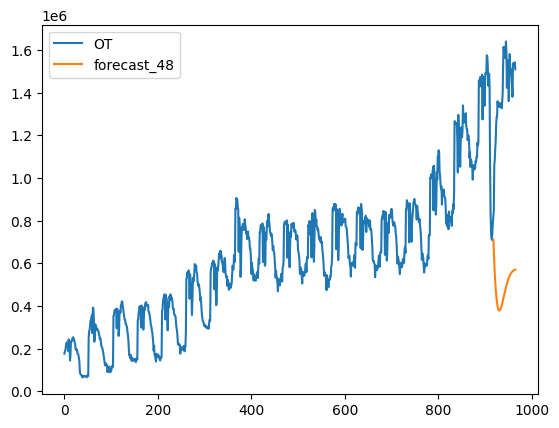

In [ ]:
results = pd.read_csv('/content/results_VARMA_raw_national_illness.csv')
results[['OT', 'forecast_48']].plot()

In [ ]:
model_fit.save('file')

In [ ]:
mae = mean_absolute_error(y, forecast_test)
mape = mean_absolute_percentage_error(y, forecast_test)
rmse = np.sqrt(mean_squared_error(y, forecast_test))

print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

mae - manual: 54684.13101456211
mape - manual: 1.0247263141539051
rmse - manual: 151512.9076064852
